In [1]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
import warnings
import gc
import psutil
import os


In [2]:
# Load the dataset
data = pd.read_csv('./datasets/salaries.csv')

# Data exploration
print(data.head())
print(data.info())
print(data.describe())

   work_year experience_level employment_type                  job_title  \
0       2024               SE              FT                AI Engineer   
1       2024               SE              FT                AI Engineer   
2       2024               SE              FT              Data Engineer   
3       2024               SE              FT              Data Engineer   
4       2024               SE              FT  Machine Learning Engineer   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0  202730             USD         202730                 US             0   
1   92118             USD          92118                 US             0   
2  130500             USD         130500                 US             0   
3   96000             USD          96000                 US             0   
4  190000             USD         190000                 US             0   

  company_location company_size  
0               US            M  
1           

In [3]:
# Handling missing values (if any)
data = data.dropna()

# Convert categorical features to numerical using OneHotEncoder
categorical_features = ['experience_level', 'employment_type', 'job_title', 'employee_residence', 'company_location', 'company_size']
numerical_features = ['remote_ratio']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)])

In [4]:
# Splitting the data into train and test sets
X = data.drop(columns=['salary_in_usd', 'salary', 'salary_currency', 'work_year'])
y = data['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(max_iter=5000),
    # 'Neural Network Regression': MLPRegressor(max_iter=1000),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'KNN': KNeighborsRegressor(),
    'Support Vector Machines': SVR(),
    # 'Gaussian Process': GaussianProcessRegressor(),
    # 'Polynomial Regression': make_pipeline(PolynomialFeatures(), LinearRegression()),
    'Gradient Boosting': GradientBoostingRegressor()
}

# Define the parameter grids
param_grids = {
    'Linear Regression': {
        'model__fit_intercept': [True, False],
        'model__n_jobs': [None, -1]
    },
    'Ridge Regression': {
        'model__alpha': [0.1, 1.0, 10.0],
        'model__fit_intercept': [True, False]
    },
    'Lasso Regression': {
        'model__alpha': [0.1, 1.0, 10.0],
        'model__fit_intercept': [True, False]
    },
    # 'Neural Network Regression': {
    #     'model__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    #     'model__activation': ['relu', 'tanh'],
    #     'model__solver': ['adam', 'sgd'],
    #     'model__alpha': [0.0001, 0.001, 0.01]
    # },
    'Decision Tree': {
        'model__max_depth': [None, 10, 20, 30, 40, 50],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    },
    'Support Vector Machines': {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 1.0, 10.0, 100.0]
    },
    # 'Gaussian Process': {
    #     'model__alpha': [1e-10, 1e-2, 1e-1, 1]
    # },
    # 'Polynomial Regression': {
    #     'model__polynomialfeatures__degree': [2, 3, 4],
    #     'model__linearregression__fit_intercept': [True, False],
    #     'model__linearregression__n_jobs': [None, -1]
    # },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.05],
        'model__max_depth': [3, 4, 5],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
}


In [6]:
# Function to perform grid search for a given model and its parameter grid
def perform_grid_search(model_name, model, param_grid, X_train, y_train):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=2, error_score=np.nan)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        grid_search.fit(X_train, y_train)
    return grid_search


In [7]:
# Perform grid search for each model
best_estimators = {}
for model_name, model in models.items():
    print(f"Performing grid search for {model_name}...")
    grid_search = perform_grid_search(model_name, model, param_grids[model_name], X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best R2 score for {model_name}: {grid_search.best_score_}")
    # Clear memory
    del grid_search
    gc.collect()

Performing grid search for Linear Regression...
Best parameters for Linear Regression: {'model__fit_intercept': True, 'model__n_jobs': None}
Best R2 score for Linear Regression: 0.3164908235311629
Performing grid search for Ridge Regression...
Best parameters for Ridge Regression: {'model__alpha': 10.0, 'model__fit_intercept': True}
Best R2 score for Ridge Regression: 0.32572313461942815
Performing grid search for Lasso Regression...


/home/flo/afs/projects/epita/ftml_project_2025/.GPU/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2637267455144.301, tolerance: 4874456408.402365
  model = cd_fast.sparse_enet_coordinate_descent(
/home/flo/afs/projects/epita/ftml_project_2025/.GPU/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 461566701527.7344, tolerance: 5042226671.428914
  model = cd_fast.sparse_enet_coordinate_descent(
/home/flo/afs/projects/epita/ftml_project_2025/.GPU/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:658: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2610083895790.211, tolerance: 4874444709.635684
  model = cd_fast.sparse

Best parameters for Lasso Regression: {'model__alpha': 10.0, 'model__fit_intercept': True}
Best R2 score for Lasso Regression: 0.325081022760493
Performing grid search for Decision Tree...
Best parameters for Decision Tree: {'model__max_depth': 40, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
Best R2 score for Decision Tree: 0.3116316919624512
Performing grid search for Random Forest...
Best parameters for Random Forest: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 100}
Best R2 score for Random Forest: 0.32325090107437005
Performing grid search for KNN...
Best parameters for KNN: {'model__n_neighbors': 9, 'model__weights': 'distance'}
Best R2 score for KNN: 0.2733262108100828
Performing grid search for Support Vector Machines...
Best parameters for Support Vector Machines: {'model__C': 100.0, 'model__kernel': 'linear'}
Best R2 score for Support Vector Machines: 0.23016581920141582
Performing grid search

In [8]:
# Evaluate the best estimators on the test set
results = {}
for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'R2': r2}

# Print the results
for model_name, result in results.items():
    print(f"{model_name}: MSE = {result['MSE']}, R2 = {result['R2']}")

Linear Regression: MSE = 3330859953.7592597, R2 = 0.30340991495305836
Ridge Regression: MSE = 3306803771.933015, R2 = 0.3084408372904973
Lasso Regression: MSE = 3315831315.8329544, R2 = 0.30655288713338347
Decision Tree: MSE = 3339198533.409747, R2 = 0.3016660494082617
Random Forest: MSE = 3258100986.795791, R2 = 0.3186261581120684
KNN: MSE = 3614819473.0009575, R2 = 0.2440248347021703
Support Vector Machines: MSE = 3709059740.4780087, R2 = 0.22431615981099218
Gradient Boosting: MSE = 3264317413.1327724, R2 = 0.31732610316803556


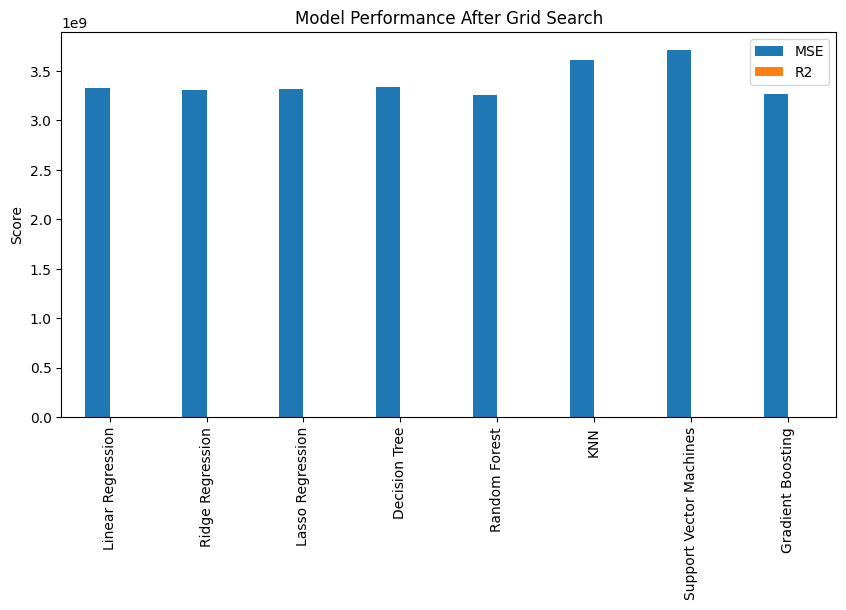

In [9]:
# Visualize the results
results_df = pd.DataFrame(results).T
results_df.plot(kind='bar', figsize=(10, 5))
plt.title('Model Performance After Grid Search')
plt.ylabel('Score')
plt.show()

In [10]:
# # Predicting salaries for new data
# new_data = pd.DataFrame({
#     'experience_level': ['SE'],
#     'employment_type': ['FT'],
#     'job_title': ['Data Scientist'],
#     'employee_residence': ['US'],
#     'remote_ratio': [1],
#     'company_location': ['US'],
#     'company_size': ['M']
# })
# predicted_salary = pipeline.predict(new_data)
# print(f"Predicted Salary in USD: {predicted_salary[0]}")